In [3]:
from typing import Union
import sqlite3
import datetime
import pickle

# EDA
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
import sklearn
from sklearn.model_selection import train_test_split

# Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Model Development

Aim: Predict the species of the flower based on the given features such as petal length and sepal width

Problem Type: Classification 

For this problem, as the main aim is to correctly predict the species and since the dataset has balanced classes, accuracy will be used as the main metric. 

- Accuracy = True Positive / Total number of Samples

- If the dataset becomes unbalanced in the future or if greater weightage is placed on False Negatives/Positives, other metrics like recall and F1 score can be included.

In [177]:
df = pd.read_csv("../data/Iris.csv")

In [178]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### Exploratory Data Analysis

In [179]:
# basic statistics and size of dataset
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [180]:
# Get number of classes
num_classes = df["Species"].nunique()
classes = list(df["Species"].unique())
print(f"There are {num_classes} in the dataset - {classes}")

There are 3 in the dataset - ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


In [181]:
"""
Dataset is balanced with same number of rows for each species
"""

df[["Id", "Species"]].groupby("Species").count()

,Id
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


In [182]:
# Statistics species by group

"""
From the statistics below, it seems like petal length and width could be key features in differentiating the different species.
"""
stats_dict = {col: ["mean", "median", "max"] for col in df.columns if col not in ["Id", "Species"]}
df.groupby("Species").aggregate(stats_dict)

SepalLengthCm             SepalWidthCm              \
                         mean median  max         mean median  max   
Species                                                              
Iris-setosa             5.006    5.0  5.8        3.418    3.4  4.4   
Iris-versicolor         5.936    5.9  7.0        2.770    2.8  3.4   
Iris-virginica          6.588    6.5  7.9        2.974    3.0  3.8   

                PetalLengthCm             PetalWidthCm              
                         mean median  max         mean median  max  
Species                                                             
Iris-setosa             1.464   1.50  1.9        0.244    0.2  0.6  
Iris-versicolor         4.260   4.35  5.1        1.326    1.3  1.8  
Iris-virginica          5.552   5.55  6.9        2.026    2.0  2.5

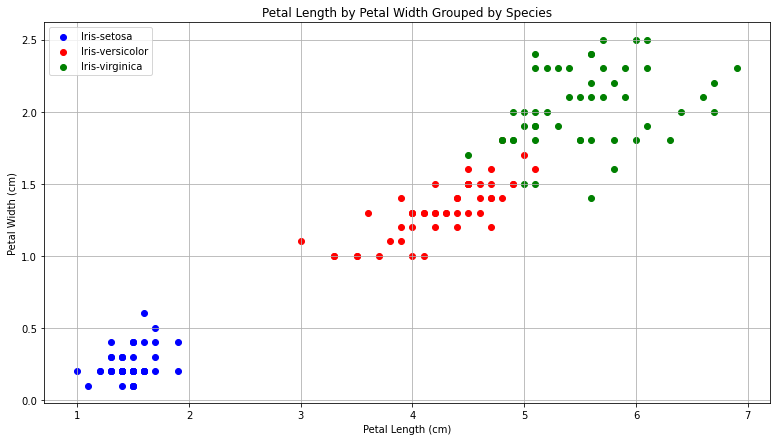

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 7)
colour = ["blue", "red", "green"]

for c in range(len(classes)):
    species = classes[c]
    temp_species = df[df["Species"] == species]
    ax.scatter(temp_species['PetalLengthCm'], temp_species['PetalWidthCm'], label=species, facecolor=colour[c])

ax.set_xlabel("Petal Length (cm)")
ax.set_ylabel("Petal Width (cm)")
ax.grid()
ax.set_title("Petal Length by Petal Width Grouped by Species")
ax.legend()

Based on the plot above, we can see that petal size differed across species with Iris-virginica having the largest petals followed by Iris-versicolor and lastly Iris-setosa. The trend is also in line with the mean statistics obtained above on `PetalLengthCm` and `PetalWidthCm`. 

## Data Preparation

In [184]:
def train_test_split_by_species(
    X: pd.DataFrame, 
    y: pd.Series, 
    test_size: float = 0.25,
    random_state: int = 42) -> Union[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    
    """
    Function performs train test split by species to ensure that each species has some rows in train set and test set
    Outputs: X_train, X_test, y_train, y_test
    
    Note: As the dataset here is small, validation set is not used.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=test_size,
                                                    random_state=random_state)

    print(f"Number of train rows: {len(X_train)}")
    print(f"Number of test rows: {len(X_test)}")
    return X_train, X_test, y_train, y_test

In [62]:
# Train test split
X = df.drop(["Species", "Id"], axis=1)
y = df["Species"]
X_train, X_test, y_train, y_test = train_test_split_by_species(X=X, y=y, test_size=0.25)

Number of train rows: 112
Number of test rows: 38


## Model Training

In [149]:
def push_metric_to_db(db_name:str, model_name: str, train_acc: float, test_acc: float) -> bool:
    """
    Creates a simple table in sqlite db that tracks the metric of each model trained. 
    Cols: id, model_name, timestamp, accuracy_metric

    Output: Boolean on whether the metric was pushed to db and model id 
    """

    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    metric_table_name = "iris_model_metric"
   
    try:
        # create metric table if it does not exist
        create_query = f"""
        CREATE TABLE IF NOT EXISTS {metric_table_name} (id INTEGER PRIMARY KEY, model_name TEXT, updated_at TIMESTAMP, test_acc FLOAT, train_acc FLOAT);
        """
        c.execute(create_query)

        # update table with new metric
        timestamp = datetime.datetime.now()
        insert_query = f"""
        INSERT INTO '{metric_table_name}' (model_name, updated_at, test_acc, train_acc)
        VALUES (?, ?, ?, ?);
        """
        c.execute(insert_query, (model_name, timestamp, test_acc, train_acc))
        conn.commit()

        # get model id (to save model weights with unique name)
        model_ver_query = f"""
        SELECT 
            id
        FROM 
            {metric_table_name}
        ORDER BY updated_at DESC
        LIMIT 1
        """
        c.execute(model_ver_query)
        sql_result = c.fetchone()
        model_ver = sql_result[0]

    except Exception as e:
        print("[ERROR]: Failed to update table")
        print(str(e))

        # default model version is 0
        return False, 0
        
    finally:
        c.close()
        conn.close()

    return True, model_ver 
    

In [150]:
def train_model(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series,
    model: sklearn.base.BaseEstimator,
    model_name: str,
    db_name: str = "../data/database.sqlite") -> sklearn.base.BaseEstimator:

    """
    Function is model agnostic and takes in any sklearn model for training. 
    After training the weights are saved in the form of a pickle file with the metrics saved to the SQLite database
    Outputs: model (i.e. trained_model) 
    """

    # train given model
    model.fit(X_train,y_train)

    # obtain predictions for test set
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    train_acc, test_acc = accuracy_score(y_train, train_prediction), accuracy_score(y_test, test_prediction)
    print("[SUCCESS]: Completed model training \n")

    # push model metrics to database and return model version
    pushed_bool, model_ver = push_metric_to_db(db_name=db_name, model_name=model_name, train_acc=train_acc, test_acc=test_acc)
    if not pushed_bool:
        print("[ERROR]: Unable to update metrics table with model training results")
    else:
        print(f"[SUCCESS]: Pushed model metrics to {db_name} for model: {model_name}")
        print(f"Train acc: {train_acc}, Test acc: {test_acc} \n")

    # save model to pickle file under assets: filename is a combination of model_name + model_id to uniquely differentiate the weights
    filename = f"../src/bentoml/assets/{model_name}_{model_ver}.pkl"
    pickle.dump(model, open(filename, 'wb'))
    print(f"[SUCCESS]: Saved model weights to {filename} in the assets folder")

    return model


In [9]:
model = LogisticRegression()
model = train_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model=model, model_name="log_reg")

[SUCCESS]: Completed model training 

[SUCCESS]: Pushed model metrics to ../data/database.sqlite for model: log_reg
Train acc: 0.9732142857142857, Test acc: 0.9473684210526315 

[SUCCESS]: Saved model weights to ../src/bentoml/assets/log_reg_1.pkl in the assets folder


In [7]:
# Check metrics database
db_name = "../data/database.sqlite"
conn = sqlite3.connect(db_name)
c = conn.cursor()
metric_table_name = "iris_model_metric"

create_query = f"""
SELECT * FROM {metric_table_name}
"""

try:
    c.execute(create_query)
    sql_result = c.fetchall()
    print(sql_result)
finally:
    c.close()
    conn.close()

[(1, 'log_reg', '2023-02-13 22:35:22.837748', 0.9473684210526315, 0.9732142857142857)]


In [8]:
# test model prediction from saved pickle file
filename = f"../src/bentoml/assets/log_reg_1.pkl"
loaded_model = pickle.load(open(filename, 'rb'))
sample = {'SepalLengthCm': 4.4,
            'SepalWidthCm': 3.2,
            'PetalLengthCm': 1.3,
            'PetalWidthCm': 0.2}
loaded_model.predict([list(sample.values())])[0]

'Iris-setosa'